In [126]:
import torch
import os
import torch.nn as nn
import pandas as pd
import numpy as np      
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve


In [127]:
# import dataset
df = pd.read_csv("../3 - Cleaning & Transforming Data/1 cleaned_dataset_MERGED_DRUG(Mogran)_ALLELESEQ.csv", index_col = None)

if(df.isna().any().sum()) != 0:
    raise Exception('There are still missing values in the dataset!')

In [128]:
df['ADR'].value_counts()

SJS            5805
TEN            3738
MPexanthema    1896
MPeruption     1634
Name: ADR, dtype: int64

In [129]:
# Drop unnecessary columns
df_stratify = pd.DataFrame()
df['ADR'] = df['ADR'].replace({'SJS': 0, 'TEN': 1, 'MPexanthema':2,'MPeruption':3})
df_stratify['ADR'] = df['ADR'].copy()
df.drop(columns=['No_ADR','ADR','ADR_MPeruption','ADR_MPexanthema','ADR_SJS','ADR_TEN','Cohort ethnicity','Allele','Drug'], inplace=True)


In [130]:
df_stratify['ADR'].value_counts()

0    5805
1    3738
2    1896
3    1634
Name: ADR, dtype: int64

In [131]:
df.dtypes

Cohort ethnicity_Black          int64
Cohort ethnicity_Caucasian      int64
Cohort ethnicity_Diverse        int64
Cohort ethnicity_Mongol         int64
Yes_ADR                       float64
                               ...   
p2.54.S                         int64
p2.54.T                         int64
p2.54.V                         int64
p2.54.W                         int64
p2.54.Y                         int64
Length: 4090, dtype: object

In [132]:
# Select output columns and drop unnecessary columns
df_output = df['Yes_ADR'].copy()
df.drop(columns = ['Yes_ADR'], inplace = True)
df_input = df.copy()
# Check input dtypes
df_input.dtypes.value_counts()

int64    4089
dtype: int64

In [133]:
df_input

,Cohort ethnicity_Black,Cohort ethnicity_Caucasian,Cohort ethnicity_Diverse,Cohort ethnicity_Mongol,0,1,2,3,4,5,...,p2.54.M,p2.54.N,p2.54.P,p2.54.Q,p2.54.R,p2.54.S,p2.54.T,p2.54.V,p2.54.W,p2.54.Y
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13069,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13070,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13071,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
df_output

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
13068    0.0
13069    0.0
13070    0.0
13071    0.0
13072    0.0
Name: Yes_ADR, Length: 13073, dtype: float64

In [135]:
df_stratify

,ADR
0,1
1,1
2,1
3,1
4,1
...,...
13068,2
13069,2
13070,2
13071,2


In [136]:
# # Change all input dtypes to float64
# df_input = df_input.astype('float64')
# df_input.dtypes.value_counts()

In [137]:
# Convert to numpy array
np_input = df_input.to_numpy()
np_output = df_output.to_numpy()
np_stratify = df_stratify.to_numpy()

In [138]:
np_input

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [139]:
def get_dataloaders(batch_size):

    # Train Test Splits
    X_train, X_test, y_train, y_test = train_test_split(np_input, np_output, test_size = 0.2, random_state = 128, stratify = np_stratify, shuffle = True)

    # See Distribution
    print('BEFORE applying weight train_label data distribution 0/1: {}/{}'.format(
    len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))

    print('BEFORE applying weight test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0])))

    # Find Weight of each class in train_labels
    weight = (1/pd.DataFrame(y_train).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in y_train])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

    # Create TensorDataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0])

    return train_loader, test_loader

In [140]:
# Function to check dataloader classes distribution
def get_dataloader_distribution(*args):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(target.numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])

        X_axis = np.arange(len(batch_count))

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis,class_0_count,width=(1/3) ,label = "NoADR",color='green',alpha=0.5)
        ax[index].bar(X_axis+(1/3),class_1_count,width=(1/3), label = 'ADR',color='red',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()

        ax[index].set_title(f"{dataloader} Data Distribution")
    fig.show()

In [141]:
# Define Network Classes
class Network(nn.Module):
    def __init__(self):
        super().__init__()

    # Define Layers    
        self.layers = nn.Sequential(
            #Input Layer
            nn.Linear(df_input.shape[1],2048), 
            nn.ReLU(),
            nn.Dropout(0.2),

            #Hidden 1
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            #Hidden 2
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Dropout(0.2),

            #Output Layer
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    # Define the forward pass
    def forward(self,input):
        output = self.layers(input)
        return output
        


In [142]:
# Empty CUDA cache
torch.cuda.empty_cache()

# Assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [143]:
# Define train function

def train(dataloader, model, loss_fn, optimizer):
    # Running Loss and Train Accuracy 
    running_loss = []
    running_train_acc = []

    # Set model to train mode
    model.train()

    # Loop through dataloader
    for batch_idx, (data, target) in enumerate(train_loader):

        # Move data to device
        data = data.float().to(device)
        target = target.float().to(device)
        
        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        
        # Calculate loss
        output = output.flatten()         
        loss = loss_fn(output,target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Save loss for each batch
        running_loss.append(loss.item()) 

        # Calculate accuracy
        with torch.no_grad():
            target = target.flatten()
            output = torch.round(output)
            correct = (output == target).sum().item()
            train_acc = correct/len(target)
            train_acc = round(train_acc, 8)
            running_train_acc.append(train_acc)

    train_acc = np.mean(running_train_acc)
    train_loss = np.mean(running_loss)
    #print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    return float(train_loss), float(train_acc)

In [117]:
# Define test function

def test(dataloader, model, loss_fn):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            # Move data to device
            data = data.float().to(device)
            target = target.float().to(device)    
            
            # Forward pass           
            output = model(data)

            # Calculate loss
            output = output.flatten()
            data = data.flatten()
            
            test_loss = loss_fn(output, target)

            # Calculate accuracy
            output = torch.round(output)
            correct = (output == target).sum().item()

        output = output.cpu().detach().numpy()
        target = target.cpu().detach().numpy()

        # Calculate metrics
        test_acc = correct / len(test_loader.dataset)
        test_loss = test_loss.cpu().detach().numpy()
        test_precision = precision_score(output, target, zero_division=0)
        test_f1_score = f1_score(output, target, zero_division=0)
        test_recall_score = recall_score(output, target, zero_division=0)
    #print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall_score:.4f}, Test F1 Score: {test_f1_score:.4f}")

    return float(test_loss), float(test_acc), float(test_precision), float(test_recall_score), float(test_f1_score)

In [ ]:
# Create model
model = Network().to(device)
print(model)

# Define Hyperparameters
batch_size = 64
learning_rate = 2e-5
epochs = 50

# Get train, test_loader and display data distribution
train_loader, test_loader = get_dataloaders(batch_size)
get_dataloader_distribution(train_loader,test_loader)

# Assign Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.01)

# Assign Loss Function
loss_fn = nn.BCELoss()

# Assign Run Name
name = f"Model-8_FINAL(checkBATCH_{x}))"
dir = os.path.join('logs', name)
writer = SummaryWriter()
total_train_loss = []
total_test_loss = []
total_train_acc = []
total_test_acc = []

for t in range(epochs):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    test_loss, test_acc, test_precision, test_recall, test_f1 = test(test_loader, model, loss_fn)
    print(f"epoch: {t}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}, test precision: {test_precision:.4f}, test recall: {test_recall:.4f}, test f1: {test_f1:.4f}")
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)
    total_train_acc.append(train_acc)
    total_test_acc.append(test_acc)
    with tf.summary.create_file_writer(f"{dir}_train").as_default():
        tf.summary.scalar("loss", train_loss, step=t)
        tf.summary.scalar("acc", train_acc, step=t)
    with tf.summary.create_file_writer(f"{dir}_test").as_default():    
        tf.summary.scalar("loss", test_loss, step=t) 
        tf.summary.scalar("acc", test_acc, step=t)
        tf.summary.scalar("precision", test_precision, step=t)
        tf.summary.scalar("f1_score", test_f1, step=t)
        tf.summary.scalar("recall_score", test_recall, step=t)
        # trial.report(test_loss, epoch)



Network(
  (layers): Sequential(
    (0): Linear(in_features=4089, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1024, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


epoch: 0, train loss: 0.6814, test loss: 0.6497, train acc: 0.5940, test acc: 0.6470, test precision: 0.4760, test recall: 0.5091, test f1: 0.4920
epoch: 1, train loss: 0.6487, test loss: 0.6184, train acc: 0.6266, test acc: 0.6902, test precision: 0.4867, test recall: 0.5822, test f1: 0.5302
epoch: 2, train loss: 0.6341, test loss: 0.6015, train acc: 0.6462, test acc: 0.7044, test precision: 0.3099, test recall: 0.6995, test f1: 0.4295
epoch: 3, train loss: 0.6258, test loss: 0.6070, train acc: 0.6595, test acc: 0.6849, test precision: 0.5399, test recall: 0.5640, test f1: 0.5517
epoch: 4, train loss: 0.6258, test loss: 0.6104, train acc: 0.6544, test acc: 0.6841, test precision: 0.5708, test recall: 0.5589, test f1: 0.5648
epoch: 5, train loss: 0.6208, test loss: 0.6065, train acc: 0.6603, test acc: 0.6841, test precision: 0.5506, test recall: 0.5613, test f1: 0.5559
epoch: 6, train loss: 0.6183, test loss: 0.6012, train acc: 0.6644, test acc: 0.6922, test precision: 0.5165, test rec

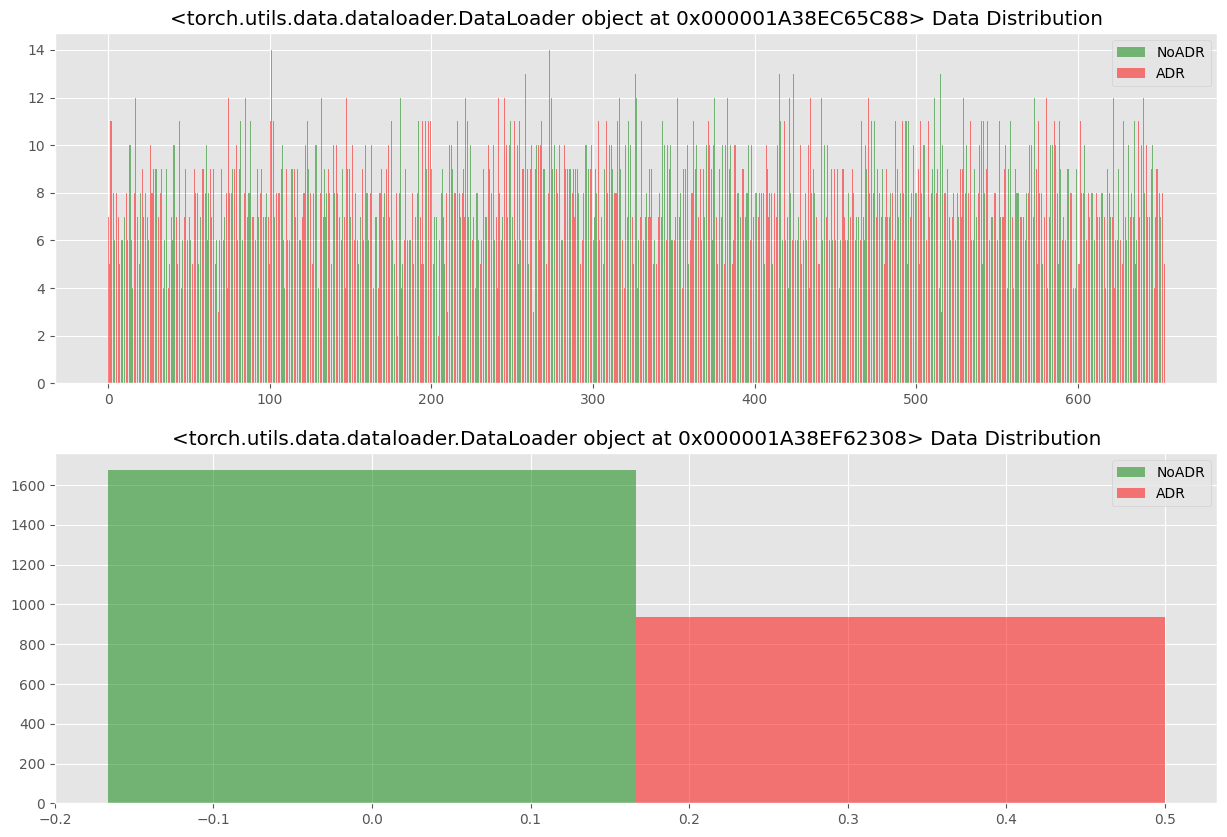

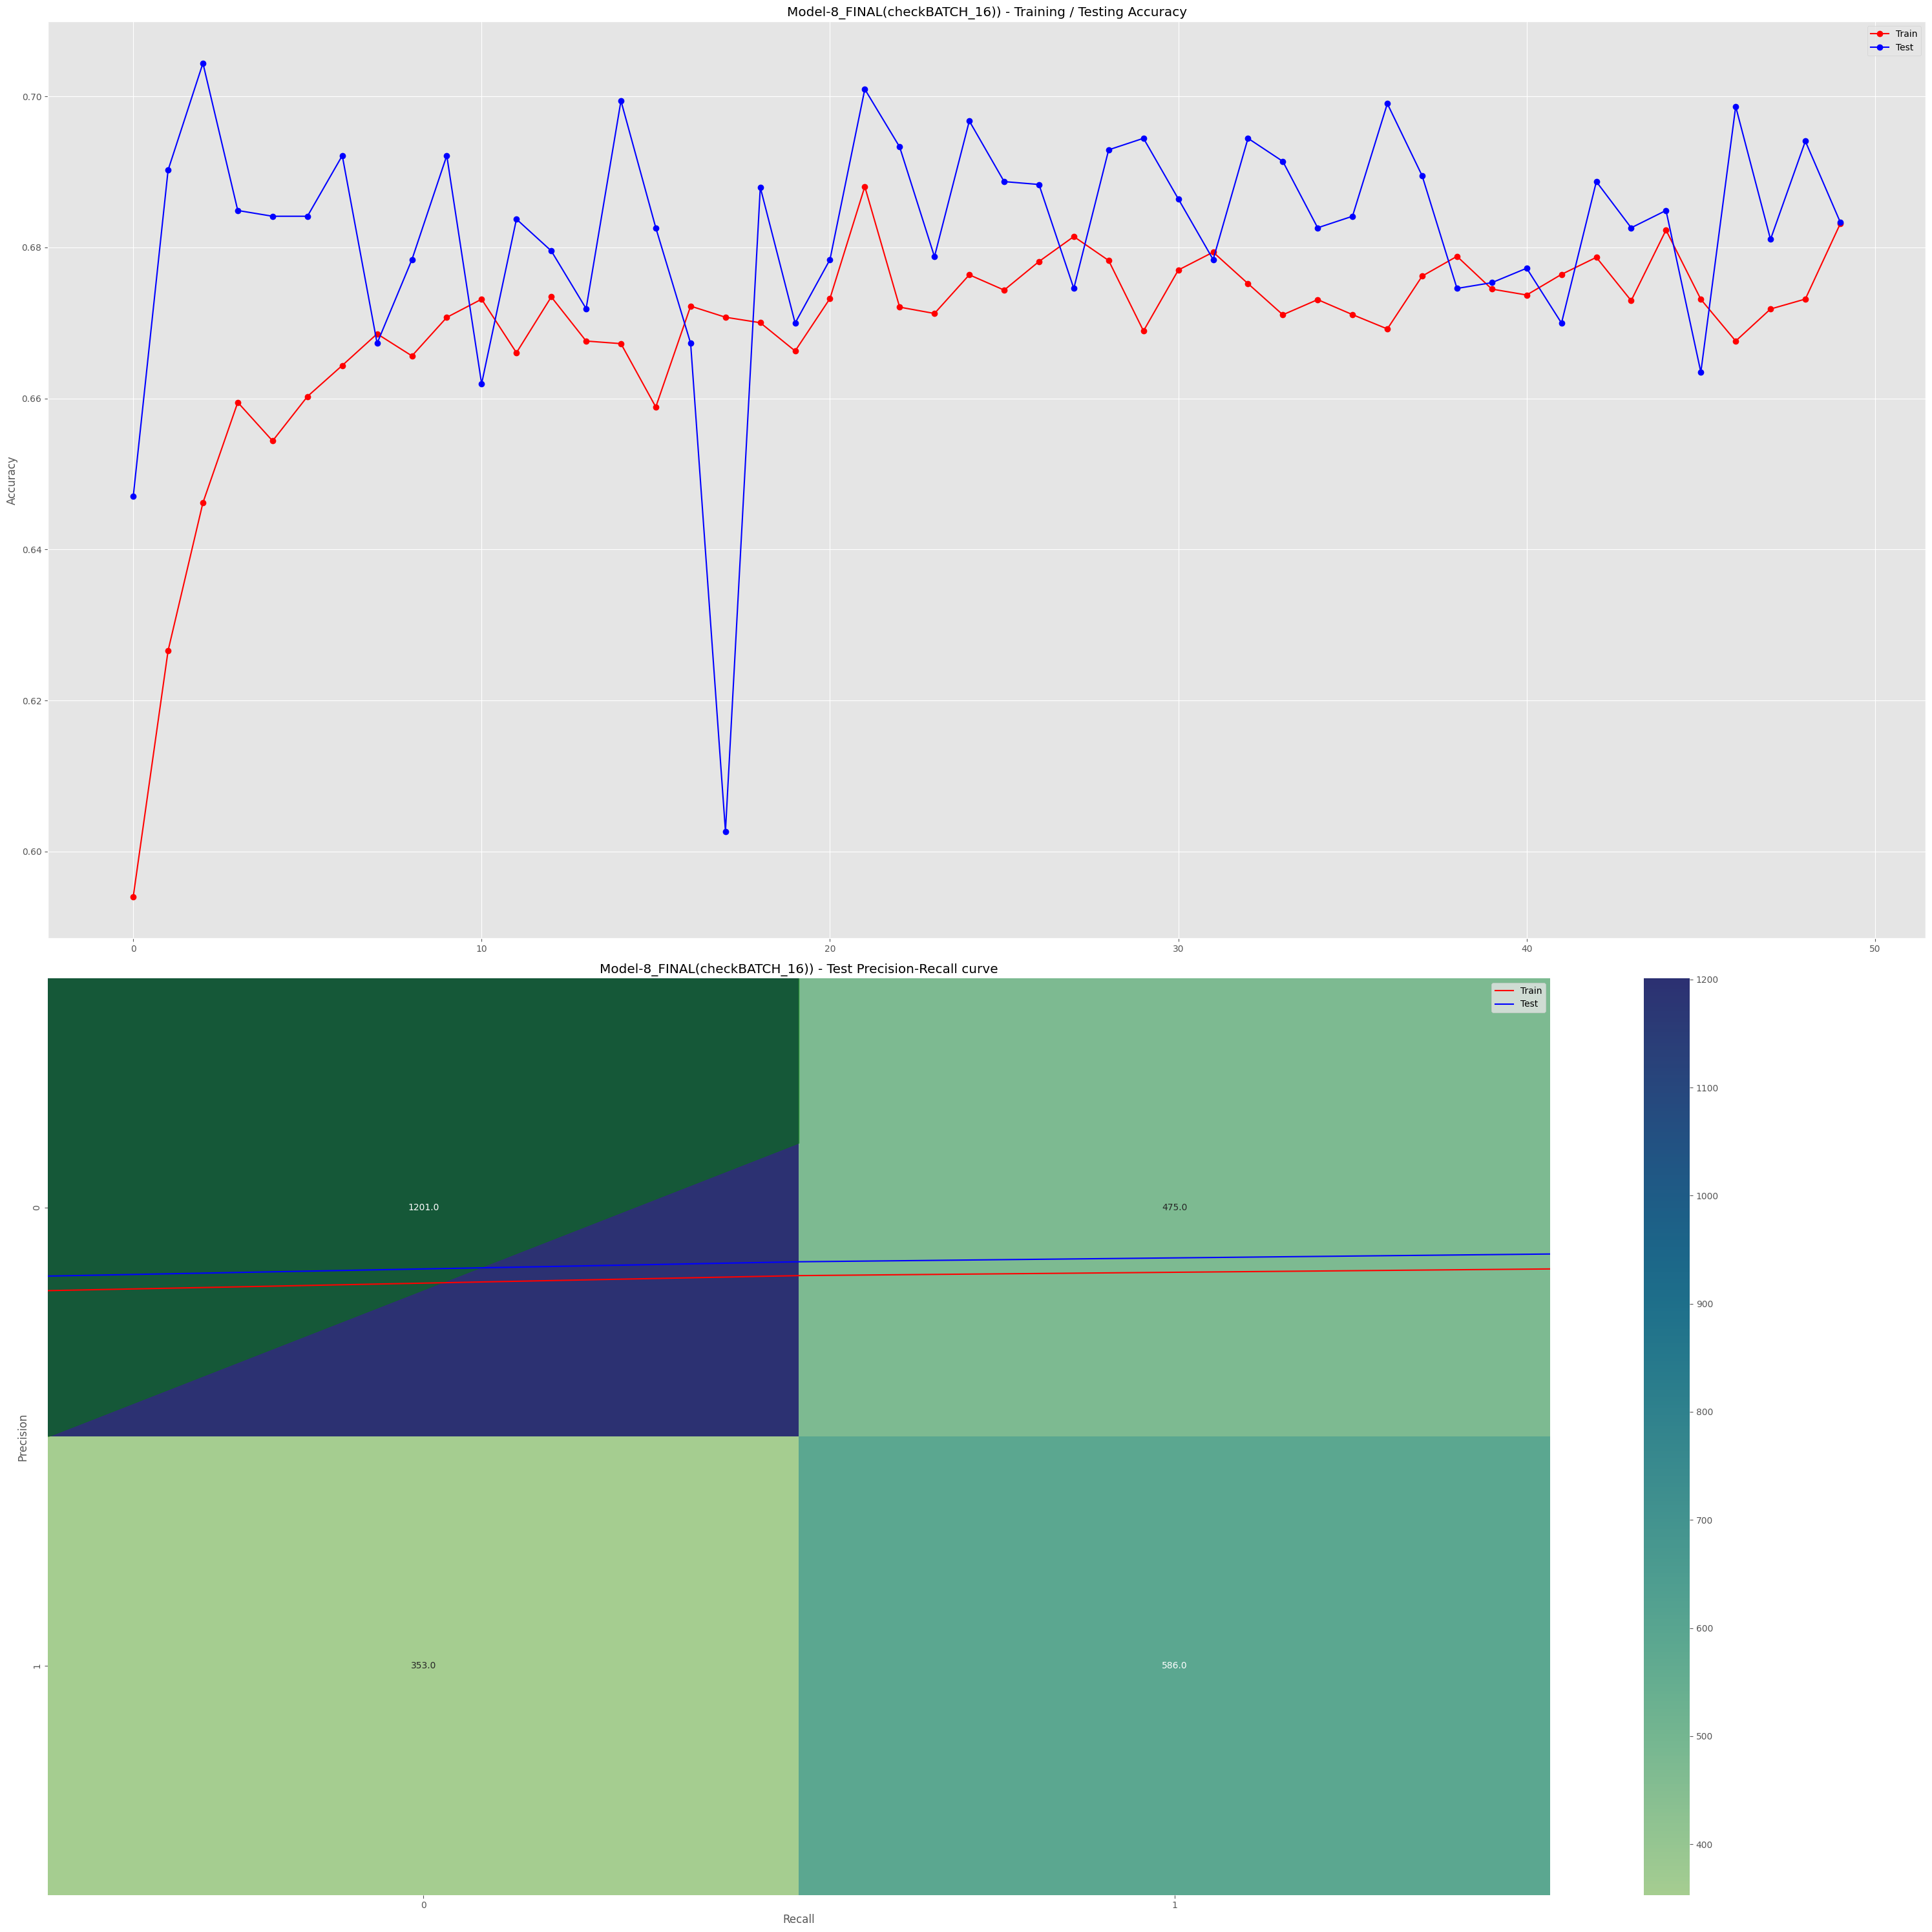

In [148]:
# Code variation for different batch sizes
for x in [16]:
    # Create model
    model = Network().to(device)
    print(model)

    # Define Hyperparameters
    batch_size = x
    learning_rate = 2e-5
    epochs = 50

    # Get train, test_loader and display data distribution
    train_loader, test_loader = get_dataloaders(batch_size)
    get_dataloader_distribution(train_loader,test_loader)

    # Assign Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.01)

    # Assign Loss Function
    loss_fn = nn.BCELoss()

    # Assign Run Name
    name = f"Model-8_FINAL(checkBATCH_{x}))"
    dir = os.path.join('logs_FINAL', name)
    writer = SummaryWriter()
    total_train_loss = []
    total_test_loss = []
    total_train_acc = []
    total_test_acc = []

    for t in range(epochs):
        train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc, test_precision, test_recall, test_f1 = test(test_loader, model, loss_fn)
        print(f"epoch: {t}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}, test precision: {test_precision:.4f}, test recall: {test_recall:.4f}, test f1: {test_f1:.4f}")
        total_train_loss.append(train_loss)
        total_test_loss.append(test_loss)
        total_train_acc.append(train_acc)
        total_test_acc.append(test_acc)
        with tf.summary.create_file_writer(f"{dir}_train").as_default():
            tf.summary.scalar("loss", train_loss, step=t)
            tf.summary.scalar("acc", train_acc, step=t)
        with tf.summary.create_file_writer(f"{dir}_test").as_default():    
            tf.summary.scalar("loss", test_loss, step=t) 
            tf.summary.scalar("acc", test_acc, step=t)
            tf.summary.scalar("precision", test_precision, step=t)
            tf.summary.scalar("f1_score", test_f1, step=t)
            tf.summary.scalar("recall_score", test_recall, step=t)
            # trial.report(test_loss, epoch)
    save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss)
    save_CFmatrix(name)
    save_PRAUC(name)
    save_model(name,optimizer,loss_fn)
    


In [80]:
writer.close()

# Save

In [81]:
torch.save(model.state_dict(), f'../4 - Training & Testing/models/model_{name}.pt')

In [96]:
def save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss):
    fig, ax = plt.subplots(2,1)
    plt.style.use('ggplot')
    fig.set_figheight(30)
    fig.set_figwidth(30)

    ax[0].set_title(f"{name} - Training / Testing Accuracy")
    ax[0].plot(total_train_acc, 'red',label='Train',marker='o')
    ax[0].plot(total_test_acc,'blue',label='Test',marker='o')
    #ax[0].xaxis.set(ticks=range(0,len(total_train_acc),1))
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()
    #ax[0].text(4,1,f"Model: {numberofmodel}")


    ax[1].set_title("Training loss")
    ax[1].set_xlabel("Epochs")
    ax[1].plot(total_train_loss,label = 'Train',color='red')
    ax[1].plot(total_test_loss,label = 'Test',color='blue')
    #ax[1].xaxis.set(ticks=range(0,len(total_train_loss),1))
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    #plt.show()

    plt.tight_layout()#h_pad = 3, w_pad=3)
    plt.savefig(f"../4 - Training & Testing/models/model_graph_{name}.png")

In [125]:
def save_CFmatrix(name):

    import seaborn as sns


    with torch.no_grad():
        data = test_loader.dataset.tensors[0].to(device)
        predicted = model(data).to(device)
        predicted = predicted.cpu()
        predicted = predicted.flatten()
        predicted = torch.round(predicted)
        target = test_loader.dataset.tensors[1].flatten()

    cf_matrix = confusion_matrix(target, predicted)
    fig, ax = plt.subplots()
    ax = sns.heatmap(cf_matrix, annot=True, fmt=".1f",cmap="crest")
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set(xlabel='Predicted', ylabel='Actual')
    ax_fig = ax.get_figure()
    ax_fig.savefig(f"../4 - Training & Testing/models/model_cf_{name}.png")
    # disp.plot(xticks_rotation=90)
    


In [94]:
def save_PRAUC(name):
    precision, recall, thresholds = precision_recall_curve(target, predicted)
    plt.fill_between(recall, precision, alpha=0.5, color='g')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title(f"{name} - Test Precision-Recall curve")
    plt.savefig(f"../4 - Training & Testing/models/model_PRAUC_{name}.png")

In [85]:
from torchsummary import summary
summary(model.cuda(),(1,1,df_input.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1, 1, 1024]       4,188,160
              ReLU-2           [-1, 1, 1, 1024]               0
           Dropout-3           [-1, 1, 1, 1024]               0
            Linear-4           [-1, 1, 1, 1024]       1,049,600
              ReLU-5           [-1, 1, 1, 1024]               0
           Dropout-6           [-1, 1, 1, 1024]               0
            Linear-7           [-1, 1, 1, 1024]       1,049,600
              ReLU-8           [-1, 1, 1, 1024]               0
           Dropout-9           [-1, 1, 1, 1024]               0
           Linear-10           [-1, 1, 1, 1024]       1,049,600
             ReLU-11           [-1, 1, 1, 1024]               0
          Dropout-12           [-1, 1, 1, 1024]               0
           Linear-13              [-1, 1, 1, 1]           1,025
          Sigmoid-14              [-1, 

In [95]:
def save_model(name,optimizer,loss_fn):
    f = open(f"../4 - Training & Testing/models/{name}.txt",'w')
    f.write(f"{str(optimizer)} \n\n{str(loss_fn)} \n\n")
    f.close()